In [96]:
import pandas as pd
import sklearn
import sys
sys.path.append('./src/')
import imp
import numpy as np
import glob
import os
import defines
from nltk import tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import feature_utils
imp.reload(feature_utils)

<module 'feature_utils' from './src/feature_utils.py'>

In [9]:
sent_db = pd.concat(map(pd.read_csv, glob.glob(os.path.join(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"*_sent_db.csv")))))

In [32]:
sent_db.reset_index(inplace=True)

In [33]:
sent_db

,index,text,sent_idx_in_block,block_idx,is_nar,doc_idx,par_db_idx,par_idx_in_doc,par_type,block_type,nar_idx,sent_len,sent_idx_in_nar,nar_len_in_sent,sent_idx_out_nar,fist_sent_in_nar,last_sent_in_nar,is_client
0,0,הפקקים,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,client,not_nar,0.000000,7.000000,NaN,NaN,1.000000,False,False,1
1,1,התחלת לעבוד,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,therapist,not_nar,0.000000,11.000000,NaN,NaN,1.000000,False,False,0
2,2,כן,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,client,not_nar,0.000000,2.000000,NaN,NaN,1.000000,False,False,1
3,3,יופי,0.000000,3.000000,0.000000,0.000000,3.000000,3.000000,therapist,not_nar,0.000000,4.000000,NaN,NaN,1.000000,False,False,0
4,4,יום שלישי כבר,0.000000,4.000000,0.000000,0.000000,4.000000,4.000000,client,not_nar,0.000000,13.000000,NaN,NaN,1.000000,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,613,בסדר,0.000000,220.000000,0.000000,3.000000,202.000000,203.000000,therapist,not_nar,0.000000,4.000000,NaN,NaN,1.000000,False,False,0
3048,614,טוב,1.000000,220.000000,0.000000,3.000000,202.000000,203.000000,therapist,not_nar,0.000000,3.000000,NaN,NaN,2.000000,False,False,0
3049,615,אז אני אמשיך את הנושא המחקרי ואז ניפרד,2.000000,220.000000,0.000000,3.000000,202.000000,203.000000,therapist,not_nar,0.000000,39.000000,NaN,NaN,3.000000,False,False,0
3050,616,כן,0.000000,221.000000,0.000000,3.000000,203.000000,204.000000,client,not_nar,0.000000,2.000000,NaN,NaN,1.000000,False,False,1


In [ ]:
stop_words = [x.strip() for x in open('heb_stopwords.txt','r').read().split('\n')]
stop_words

## Count stop-words per sentence

In [66]:
def count_stop_words_per_sent(sent_idx):
    words =  tokenize.word_tokenize(sent_db.loc[sent_idx,'text'])
    sent_stop_words = [w for w in words if w in stop_words]
    rate = len(sent_stop_words)/len(words)
    return rate

In [67]:
for i in sent_db.index:
    sent_db.loc[i,'stop_words_rate'] = count_stop_words_per_sent(i)

In [68]:
sent_db.groupby('is_nar')['stop_words_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
is_nar,,,,,,,,
0.000000,2014.000000,0.621470,0.250976,0.000000,0.500000,0.625753,0.764706,1.000000
1.000000,1038.000000,0.575458,0.220870,0.000000,0.480000,0.585366,0.698913,1.000000


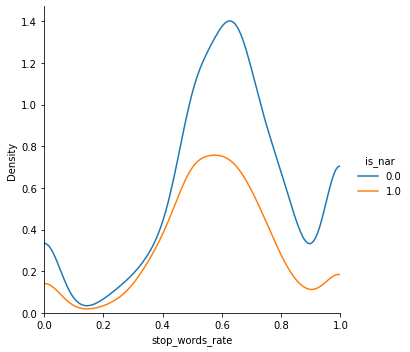

In [69]:
sns.displot(sent_db,x='stop_words_rate',hue='is_nar',kind="kde")
plt.xlim(sent_db['stop_words_rate'].min(), sent_db['stop_words_rate'].max())
plt.show()

<AxesSubplot:xlabel='stop_words_rate', ylabel='Density'>

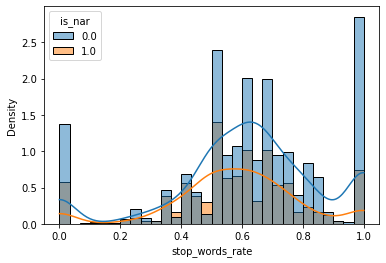

In [80]:
# fig, axes = plt.subplots(1,1,figsize=(30,30))
sns.histplot(sent_db,x='stop_words_rate',hue='is_nar',kde=True,common_norm=True,stat='density')

<AxesSubplot:xlabel='is_nar', ylabel='stop_words_rate'>

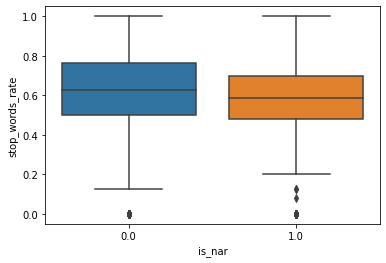

In [70]:
sns.boxplot(data=sent_db,x='is_nar',y='stop_words_rate')

## TF-IDF

In [156]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer

tfidf = TfidfVectorizer(lowercase=False,analyzer='word',min_df=5,norm='l2')

In [157]:
imp.reload(feature_utils)
X,y = feature_utils.get_label_and_drop(sent_db)
text_train,text_test,y_train, y_test = feature_utils.get_train_test_text(X,y)

total data len: 3052
len train: 2289, len test: 763


In [158]:
X_train_vec = tfidf.fit_transform(text_train)
X_test_vec = tfidf.transform(text_test)

feature_names = tfidf.get_feature_names()
feature_utils.sample_features(feature_names)

['14', 'THERAPIST', 'XXX', 'אבא', 'אבוא', 'אבל', 'אגיד', 'אדם', 'אה', 'אהה', 'אהיה', 'או', 'אוהב', 'אוהבת', 'אוכל', 'אולי', 'אומר', 'אומרים', 'אומרת', 'אוקי']
['כאלה', 'כאן', 'כבר', 'כדי', 'כוח', 'כולה', 'כולם', 'כוננויות', 'כזאת', 'כזה', 'כי', 'כיף', 'כך', 'ככה', 'כל', 'כלום', 'כלומר', 'כלל', 'כללי', 'כמה']
['14', 'אצלנו', 'בצד', 'הייתי', 'זמנים', 'כך', 'לסיים', 'מנסה', 'עונה', 'שבועיים']


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [159]:
feature_utils.cross_val_all_regerssors(X_train_vec,y_train,"TfIdf")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********
*********SVC *********
*********DecisionTreeClassifier *********


In [162]:
display(feature_utils.scores_df.sort_values(by='f1',ascending = False))

,f1,roc_auc,recall,average_precision
SGDClassifier_TfIdf,0.546325,0.723861,0.494938,0.599848
RidgeClassifier_TfIdf,0.540275,0.736971,0.464086,0.615883
RidgeClassifierCV_TfIdf,0.540275,0.736793,0.464086,0.615771
LogisticRegressionCV_TfIdf,0.525518,0.742405,0.439660,0.623633
Perceptron_TfIdf,0.521124,0.687320,0.523177,0.537392
PassiveAggressiveClassifier_TfIdf,0.518673,0.678528,0.528388,0.529091
SVC_TfIdf,0.460134,0.748023,0.343173,0.628988
LogisticRegression_TfIdf,0.456721,0.744116,0.345771,0.626351
DecisionTreeClassifier_TfIdf,0.443277,0.588108,0.411222,0.411970


In [176]:
imp.reload(feature_utils)
feature_utils.fit_predict_all_regressors(X_train_vec,y_train,X_test_vec)

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


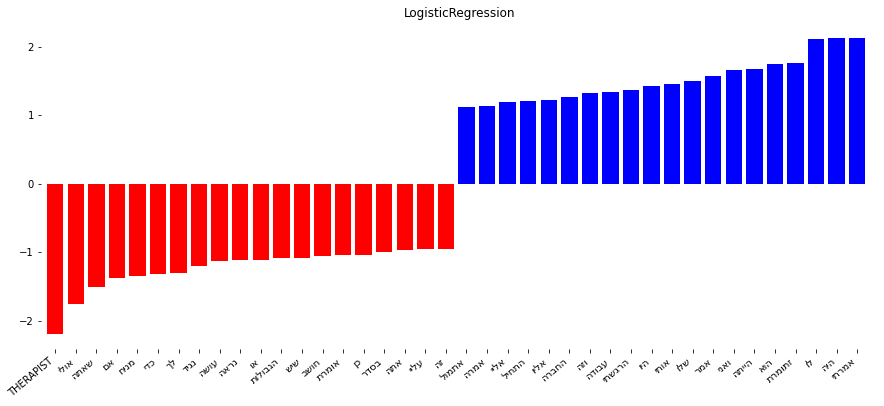

              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82       615
         1.0       0.39      0.69      0.50       148

    accuracy                           0.73       763
   macro avg       0.65      0.72      0.66       763
weighted avg       0.81      0.73      0.76       763



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


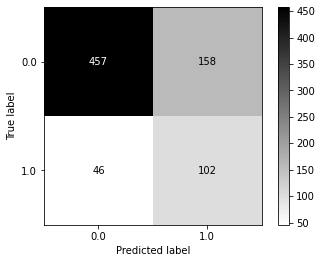

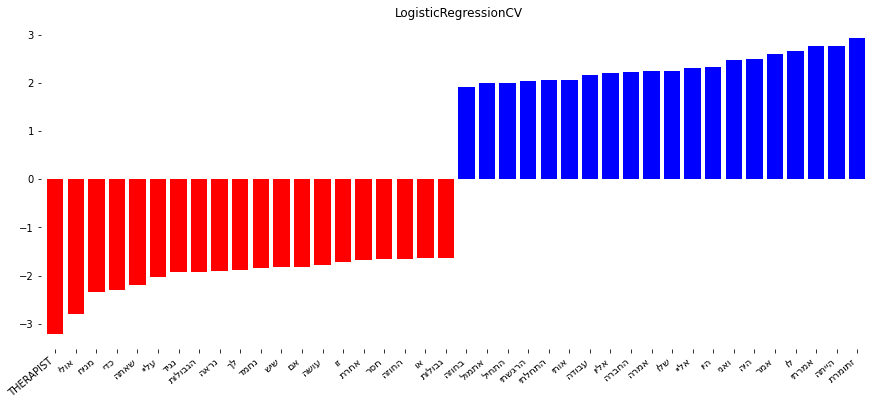

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       577
         1.0       0.47      0.66      0.55       186

    accuracy                           0.74       763
   macro avg       0.67      0.71      0.68       763
weighted avg       0.77      0.74      0.75       763



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


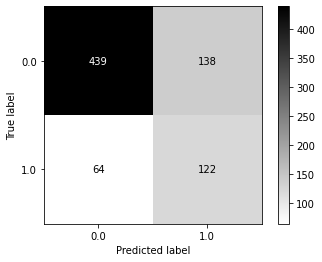

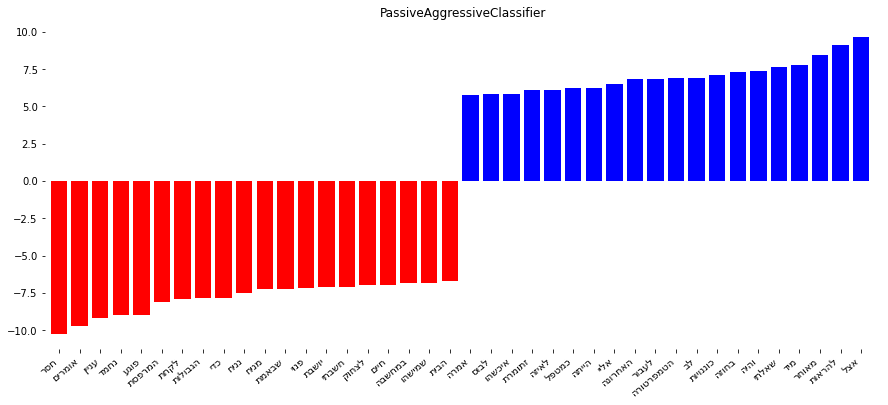

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       532
         1.0       0.50      0.57      0.53       231

    accuracy                           0.70       763
   macro avg       0.65      0.66      0.66       763
weighted avg       0.71      0.70      0.70       763



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


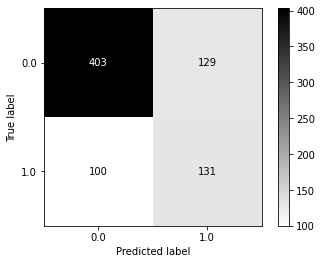

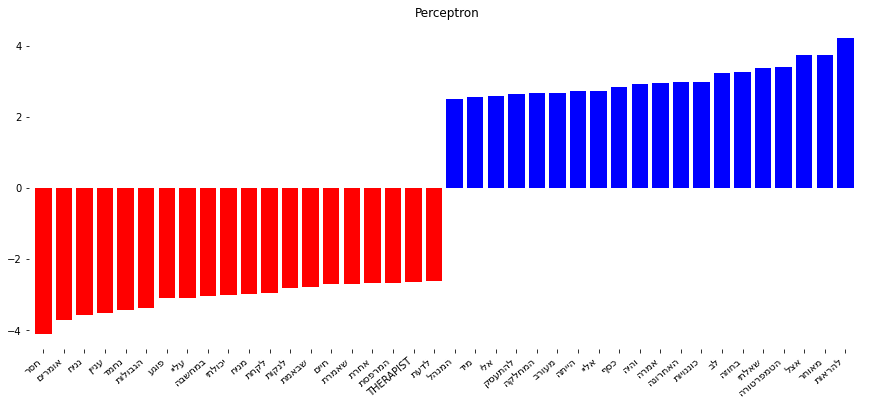

              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       487
         1.0       0.56      0.53      0.54       276

    accuracy                           0.68       763
   macro avg       0.65      0.64      0.65       763
weighted avg       0.67      0.68      0.68       763



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


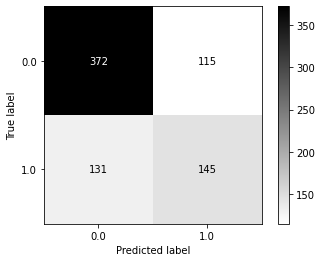

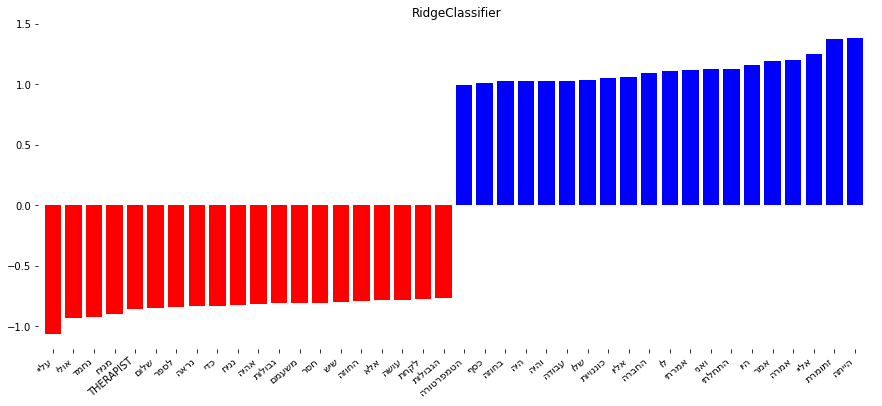

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81       567
         1.0       0.48      0.64      0.55       196

    accuracy                           0.73       763
   macro avg       0.67      0.70      0.68       763
weighted avg       0.76      0.73      0.74       763



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


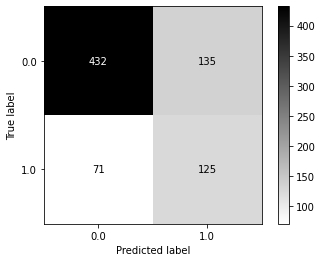

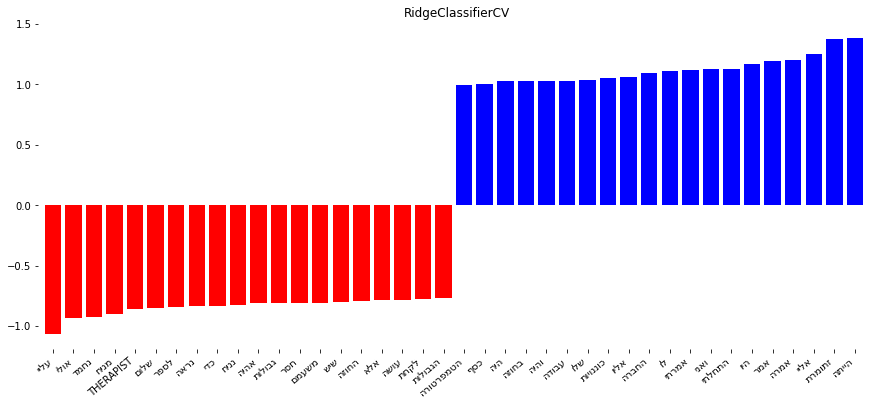

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81       566
         1.0       0.48      0.64      0.55       197

    accuracy                           0.73       763
   macro avg       0.67      0.70      0.68       763
weighted avg       0.76      0.73      0.74       763



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


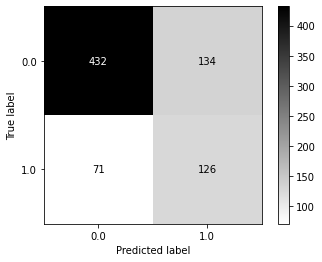

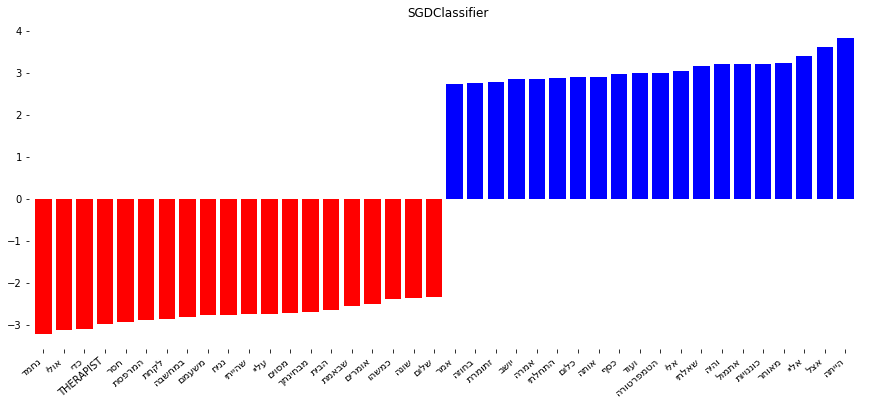

              precision    recall  f1-score   support

         0.0       0.85      0.76      0.81       563
         1.0       0.49      0.64      0.55       200

    accuracy                           0.73       763
   macro avg       0.67      0.70      0.68       763
weighted avg       0.76      0.73      0.74       763



AttributeError: coef_ is only available when using a linear kernel

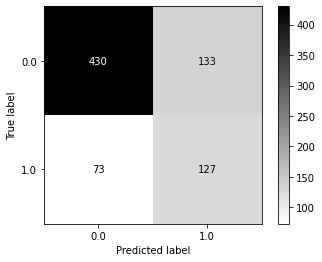

<Figure size 1080x432 with 0 Axes>

In [177]:
for name,regr in feature_utils.regressors_instances.items():
    plt.figure(figsize=(15, 6))
    feature_utils.plot_important_features(regr.coef_.ravel(), np.array(tfidf.get_feature_names()), top_n=20, rotation=40)
    ax = plt.gca()
    plt.title(name)
    plt.show()
    feature_utils.get_prediction_report(feature_utils.regressors_prediction[name],y_test)